# TDMP2 Pixels Results Analysis

This notebook loads per-task result CSVs (step, reward, seed) and produces per-task plots (mean + variation) plus summary statistics.

Execute cells top-to-bottom. Adjust filters or add metrics as needed.

In [1]:
# 1. Create Notebooks Folder (idempotent)
from pathlib import Path
NOTEBOOKS_DIR = Path("notebooks")
NOTEBOOKS_DIR.mkdir(exist_ok=True)
print(f"Ensured notebooks dir exists at: {NOTEBOOKS_DIR.resolve()}")

Ensured notebooks dir exists at: /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/notebooks


In [2]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json, re, warnings
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8,4)
print("Libraries imported.")

Libraries imported.


In [3]:
# 3. Define Paths and Configuration (updated)
# We are executing this notebook from the repository root or from within the notebooks folder.
# Results live at: <repo_root>/results/tdmpc2-pixels (NOT inside notebooks)
from pathlib import Path

# Detect repo root by climbing until 'results' exists (max 3 levels)
_here = Path.cwd().resolve()
for _ in range(3):
    if (_here / 'results' / 'tdmpc2-pixels').is_dir():
        REPO_ROOT = _here
        break
    _here = _here.parent
else:
    raise RuntimeError("Could not locate results/tdmpc2-pixels directory relative to this notebook.")

RESULTS_DIR = REPO_ROOT / 'results' / 'tdmpc2-pixels'
NOTEBOOKS_DIR = REPO_ROOT / 'notebooks'
FIGURES_DIR = NOTEBOOKS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Figures dir: {FIGURES_DIR}")

FILE_PATTERN = '*.csv'
REQUIRED_COLUMNS = {'step','reward','seed'}

Repo root: /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2
Results dir: /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/results/tdmpc2-pixels
Figures dir: /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures


In [4]:
# 4. Load Results Files

def load_task_csvs(results_dir: Path, pattern: str = FILE_PATTERN) -> pd.DataFrame:
    frames = []
    for path in sorted(results_dir.glob(pattern)):
        if not path.is_file():
            continue
        try:
            df = pd.read_csv(path)
        except Exception as e:
            warnings.warn(f"Failed to read {path.name}: {e}")
            continue
        df['__source_file'] = path.name
        frames.append(df)
    if not frames:
        raise FileNotFoundError(f"No result files matched pattern {pattern} in {results_dir}")
    data = pd.concat(frames, ignore_index=True)
    return data

raw_df = load_task_csvs(RESULTS_DIR)
print(f"Loaded rows: {len(raw_df)} from {raw_df['__source_file'].nunique()} files")
raw_df.head()

Loaded rows: 756 from 12 files


,step,reward,seed,__source_file
0,0,5.4,2,acrobot-swingup.csv
1,100000,8.0,2,acrobot-swingup.csv
2,200000,45.4,2,acrobot-swingup.csv
3,300000,48.2,2,acrobot-swingup.csv
4,400000,76.9,2,acrobot-swingup.csv


In [5]:
# 5. Inspect Raw Data Structure
print(raw_df.info())
print("Columns:", list(raw_df.columns))
print("Sample:")
raw_df.sample(min(5, len(raw_df)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           756 non-null    int64  
 1   reward         756 non-null    float64
 2   seed           756 non-null    int64  
 3   __source_file  756 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 23.8+ KB
None
Columns: ['step', 'reward', 'seed', '__source_file']
Sample:


,step,reward,seed,__source_file
210,0,0.0,3,finger-spin.csv
312,1800000,985.0,3,finger-turn-easy.csv
395,1700000,212.8,1,quadruped-run.csv
338,200000,279.8,1,finger-turn-hard.csv
732,1800000,950.7,2,walker-walk.csv


In [6]:
# 6. Clean and Normalize Data
clean_df = raw_df.copy()
# Standardize column names
clean_df.columns = [c.strip().lower().replace(' ', '_') for c in clean_df.columns]
missing_cols = REQUIRED_COLUMNS - set(clean_df.columns)
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
# Coerce types
for col in ['step','reward','seed']:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')
# Drop NaNs
before = len(clean_df)
clean_df = clean_df.dropna(subset=['step','reward','seed'])
print(f"Dropped {before - len(clean_df)} rows with NaNs")
# Remove negative or nonsensical steps
clean_df = clean_df[clean_df['step'] >= 0]
clean_df.reset_index(drop=True, inplace=True)
clean_df.head()

Dropped 0 rows with NaNs


,step,reward,seed,__source_file
0,0,5.4,2,acrobot-swingup.csv
1,100000,8.0,2,acrobot-swingup.csv
2,200000,45.4,2,acrobot-swingup.csv
3,300000,48.2,2,acrobot-swingup.csv
4,400000,76.9,2,acrobot-swingup.csv


In [7]:
# 7. Extract Task Names and Metrics
# Derive task from source filename (remove extension)
clean_df['task'] = clean_df['__source_file'].str.replace('.csv','', regex=False)
# Metrics: reward over steps
metrics_long = clean_df[['task','step','reward','seed']].copy()
metrics_long.head()

,task,step,reward,seed
0,acrobot-swingup,0,5.4,2
1,acrobot-swingup,100000,8.0,2
2,acrobot-swingup,200000,45.4,2
3,acrobot-swingup,300000,48.2,2
4,acrobot-swingup,400000,76.9,2


In [8]:
# 8. Compute Per-Task Statistics (per step aggregation)
step_stats = (metrics_long
             .groupby(['task','step'])
             .agg(mean_reward=('reward','mean'),
                  std_reward=('reward','std'),
                  n=('reward','count'))
             .reset_index())
print(step_stats.head())

              task    step  mean_reward  std_reward  n
0  acrobot-swingup       0     4.800000    2.749545  3
1  acrobot-swingup  100000    13.133333    5.783886  3
2  acrobot-swingup  200000    23.233333   19.316918  3
3  acrobot-swingup  300000    52.433333   23.142241  3
4  acrobot-swingup  400000    98.633333   45.295622  3


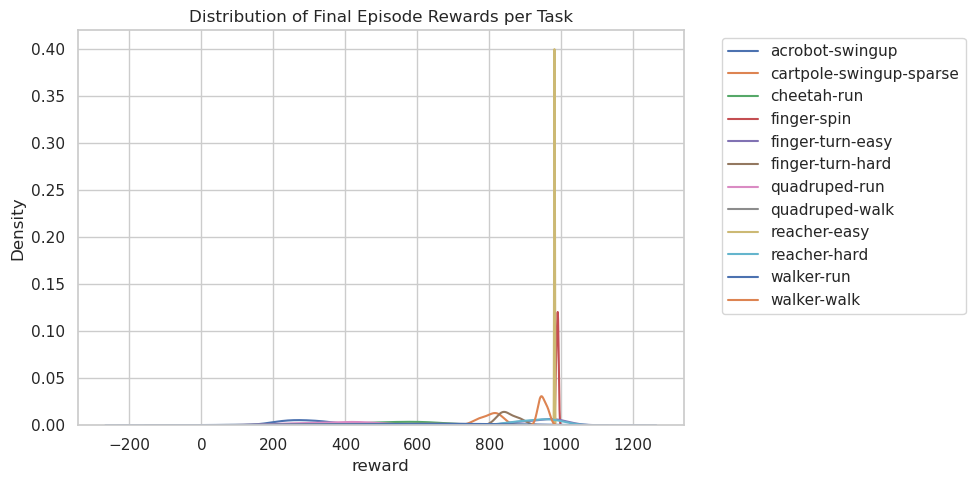

In [9]:
# 9. Plot Per-Task Reward Distributions (final step values)
final_step = metrics_long.sort_values('step').groupby(['task','seed']).tail(1)
plt.figure(figsize=(10,5))
for task in sorted(final_step['task'].unique()):
    sns.kdeplot(data=final_step[final_step.task==task], x='reward', label=task, fill=False)
plt.title('Distribution of Final Episode Rewards per Task')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

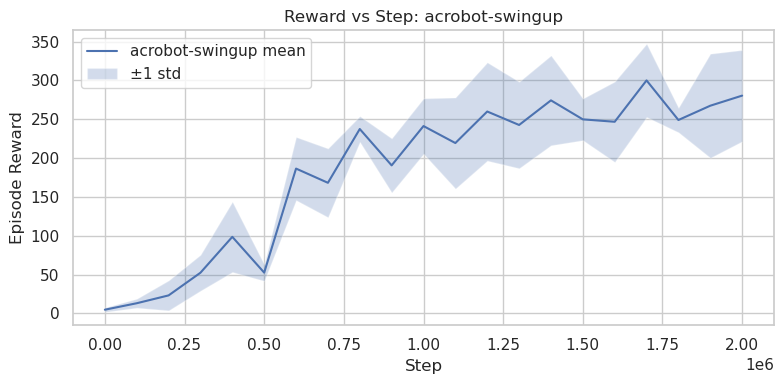

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/acrobot-swingup_reward_curve.png


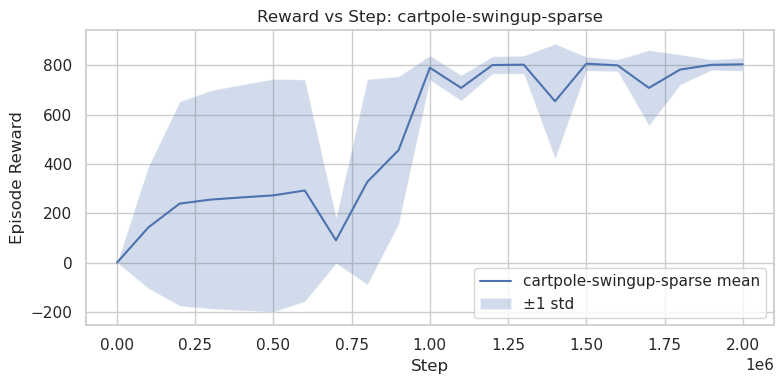

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/cartpole-swingup-sparse_reward_curve.png


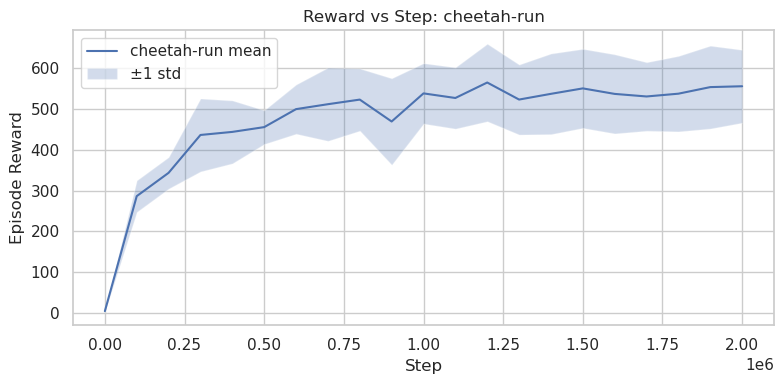

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/cheetah-run_reward_curve.png


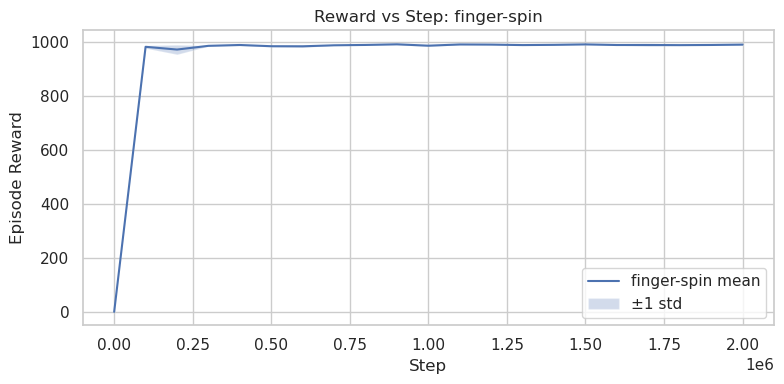

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/finger-spin_reward_curve.png


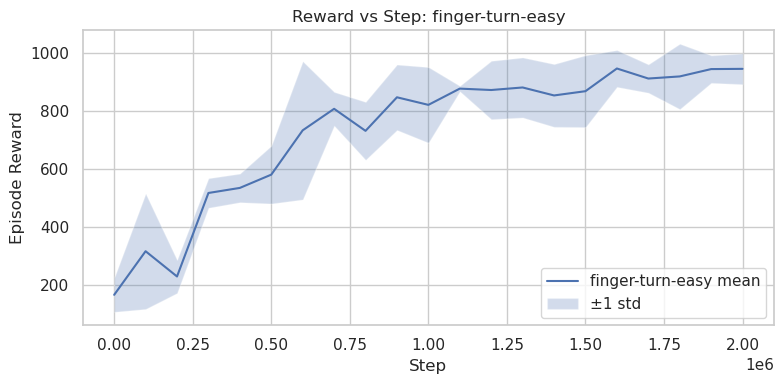

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/finger-turn-easy_reward_curve.png


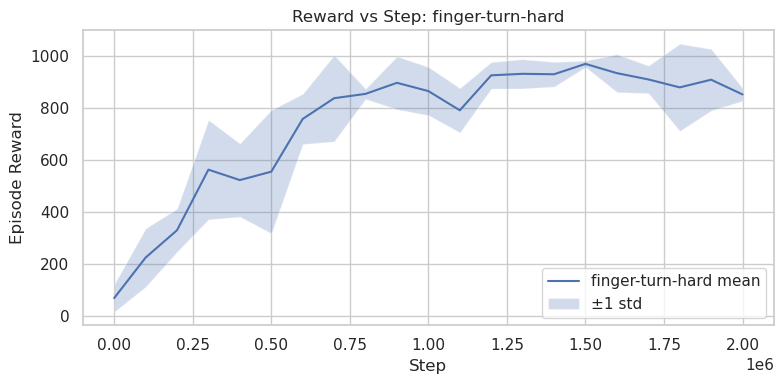

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/finger-turn-hard_reward_curve.png


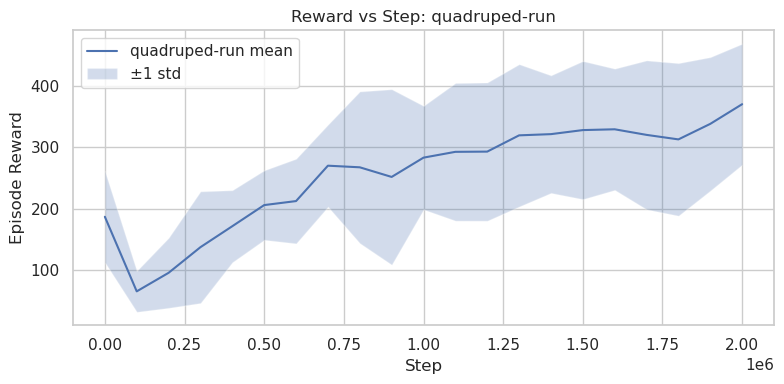

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/quadruped-run_reward_curve.png


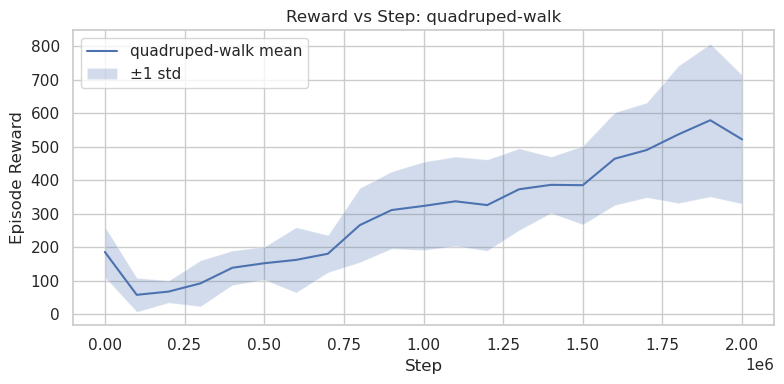

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/quadruped-walk_reward_curve.png


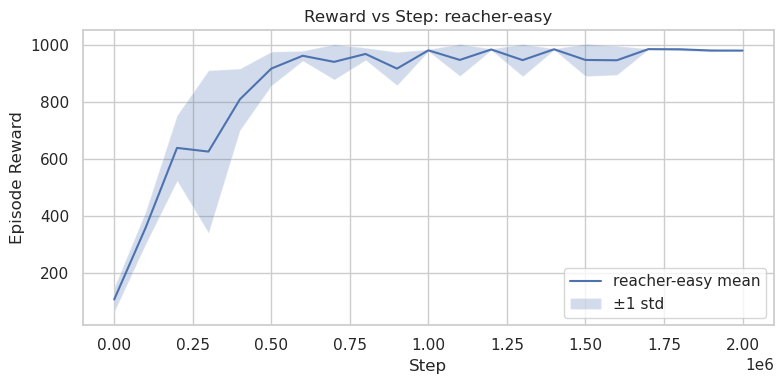

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/reacher-easy_reward_curve.png


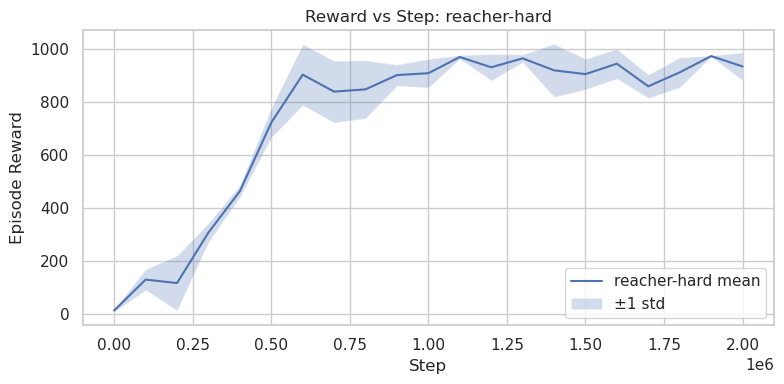

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/reacher-hard_reward_curve.png


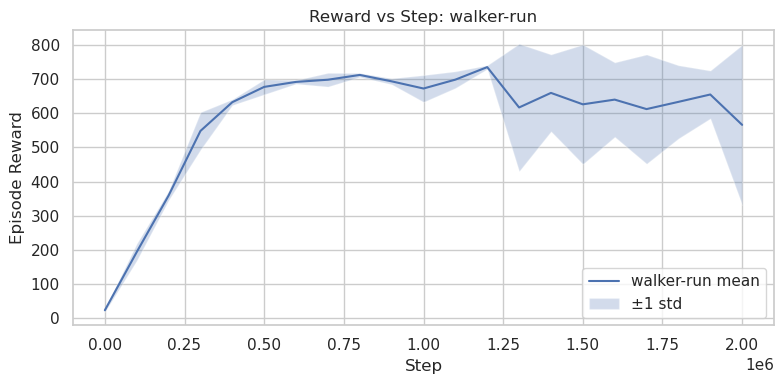

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/walker-run_reward_curve.png


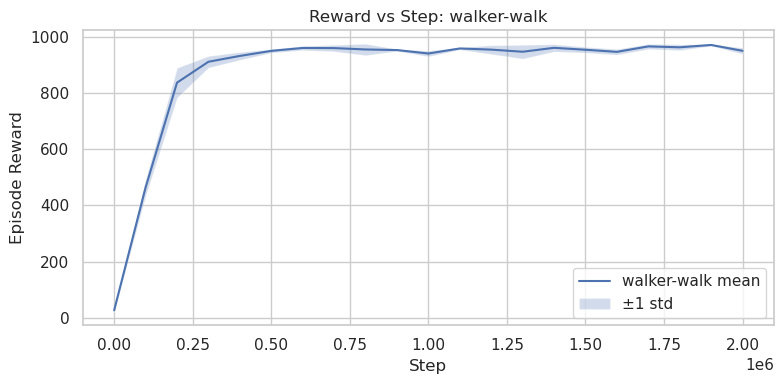

Saved /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/walker-walk_reward_curve.png


In [10]:
# 10. Plot Per-Task Mean Reward Curves with Std Shading
for task, grp in step_stats.groupby('task'):
    plt.figure()
    plt.plot(grp['step'], grp['mean_reward'], label=f'{task} mean')
    if grp['std_reward'].notna().any():
        upper = grp['mean_reward'] + grp['std_reward'].fillna(0)
        lower = grp['mean_reward'] - grp['std_reward'].fillna(0)
        plt.fill_between(grp['step'], lower, upper, alpha=0.25, label='±1 std')
    plt.title(f'Reward vs Step: {task}')
    plt.xlabel('Step')
    plt.ylabel('Episode Reward')
    plt.legend()
    out_file = FIGURES_DIR / f'{task}_reward_curve.png'
    plt.tight_layout()
    plt.savefig(out_file, dpi=120)
    plt.show()
    print(f'Saved {out_file}')

In [11]:
# 11. Combined Summary Table (Final Step)
final_stats = (step_stats.sort_values('step')
               .groupby('task')
               .tail(1)
               .rename(columns={'mean_reward':'final_mean','std_reward':'final_std','n':'final_n'}))
final_stats['cv'] = final_stats['final_std'] / final_stats['final_mean'].replace(0, np.nan)
final_stats = final_stats[['task','step','final_mean','final_std','final_n','cv']].sort_values('final_mean', ascending=False)
final_stats.reset_index(drop=True, inplace=True)
final_stats

,task,step,final_mean,final_std,final_n,cv
0,finger-spin,2000000,988.933333,2.761038,3,0.002792
1,reacher-easy,2000000,981.166667,0.802081,3,0.000817
2,walker-walk,2000000,949.166667,10.858330,3,0.011440
3,finger-turn-easy,2000000,944.666667,52.898614,3,0.055997
4,reacher-hard,2000000,935.033333,52.766688,3,0.056433
5,finger-turn-hard,2000000,852.600000,24.598374,3,0.028851
6,cartpole-swingup-sparse,2000000,803.633333,26.525522,3,0.033007
7,walker-run,2000000,565.700000,233.653996,3,0.413035
8,cheetah-run,2000000,554.766667,89.081442,3,0.160575
9,quadruped-walk,2000000,521.833333,191.892687,3,0.367728


In [12]:
# 12. Save Figures and Summary Outputs
summary_csv = FIGURES_DIR / 'final_stats.csv'
final_stats.to_csv(summary_csv, index=False)
summary_json = FIGURES_DIR / 'final_stats.json'
final_stats.to_json(summary_json, orient='records', indent=2)
print(f'Saved summary CSV: {summary_csv}')
print(f'Saved summary JSON: {summary_json}')

Saved summary CSV: /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/final_stats.csv
Saved summary JSON: /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/final_stats.json


In [13]:
# 13. Optional: Interactive Task Selector
if widgets is not None:
    task_options = sorted(step_stats.task.unique())
    multi_select = widgets.SelectMultiple(options=task_options, value=tuple(task_options[:3]), description='Tasks')
    display(multi_select)

    def update_plots(tasks):
        for task in tasks:
            grp = step_stats[step_stats.task==task]
            plt.figure()
            plt.plot(grp['step'], grp['mean_reward'])
            if grp['std_reward'].notna().any():
                plt.fill_between(grp['step'], grp['mean_reward']-grp['std_reward'].fillna(0), grp['mean_reward']+grp['std_reward'].fillna(0), alpha=0.25)
            plt.title(f'Reward vs Step: {task}')
            plt.xlabel('Step'); plt.ylabel('Episode Reward')
            plt.tight_layout(); plt.show()

    widgets.interactive_output(update_plots, {'tasks': multi_select})
else:
    print("ipywidgets not installed; skip interactive section.")

ipywidgets not installed; skip interactive section.


In [14]:
# 14. Validate Outputs
assert not step_stats.empty, "No statistics computed."
assert not final_stats.empty, "Final stats empty."
missing_tasks = set(step_stats.task.unique()) - set(final_stats.task.unique())
if missing_tasks:
    warnings.warn(f"Some tasks missing in final stats: {missing_tasks}")
print("Analysis complete. Tasks analyzed:", list(final_stats.task))

Analysis complete. Tasks analyzed: ['finger-spin', 'reacher-easy', 'walker-walk', 'finger-turn-easy', 'reacher-hard', 'finger-turn-hard', 'cartpole-swingup-sparse', 'walker-run', 'cheetah-run', 'quadruped-walk', 'quadruped-run', 'acrobot-swingup']


## Section 2: Overlay W&B Experiment Runs vs Original Baselines

This section pulls all runs from your W&B project (entity: `thomasevers9`, project: `tdmpc2-tdmpc2`), groups them by task, extracts episode/eval rewards, and overlays them with the baseline CSV curves loaded earlier. You need a valid W&B API key available to the environment (env var `WANDB_API_KEY` or prior `wandb login`). If offline, skip these cells.

In [15]:
# Fetch W&B runs metadata
import os, math, time, warnings
try:
    import wandb
except ImportError:
    # Attempt lightweight install (will use existing env packages dir)
    !python -m pip install --quiet wandb
    import wandb

WANDB_ENTITY = 'thomasevers9'
WANDB_PROJECT = 'tdmpc2-tdmpc2'

api_key = os.environ.get('WANDB_API_KEY')
if api_key is None:
    warnings.warn('WANDB_API_KEY not set; if not already logged in via `wandb login`, this may fail.')

api = wandb.Api(overrides={"entity": WANDB_ENTITY, "project": WANDB_PROJECT})
print(f"Querying runs for {WANDB_ENTITY}/{WANDB_PROJECT} ...")
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
print(f"Total runs retrieved: {len(runs)}")
# Collect minimal metadata
runs_meta = []
for r in runs:
    cfg = dict(r.config)
    task = cfg.get('task') or cfg.get('Task') or 'unknown'
    runs_meta.append({
        'id': r.id,
        'name': r.name,
        'task': task,
        'state': r.state,
        'created_at': r.created_at,
        'step': r.summary.get('global_step') or r.summary.get('_step'),
        'final_eval_reward': r.summary.get('eval/episode_reward') or r.summary.get('eval_episode_reward')
    })
import pandas as pd
runs_df = pd.DataFrame(runs_meta)
print(runs_df.head())

/tmp/ipykernel_2214770/2951275288.py:15: UserWarning: WANDB_API_KEY not set; if not already logged in via `wandb login`, this may fail.
  warnings.warn('WANDB_API_KEY not set; if not already logged in via `wandb login`, this may fail.')


Querying runs for thomasevers9/tdmpc2-tdmpc2 ...
Total runs retrieved: 44
         id              name         task     state            created_at  \
0  qr3rnacb  confused-sweep-1   walker-run   crashed  2025-08-26T10:30:13Z   
1  trnfpjo7    astral-sweep-2  cheetah-run  finished  2025-08-26T10:34:12Z   
2  fy4f0dpg    honest-sweep-3  cheetah-run  finished  2025-08-26T10:34:20Z   
3  ic63c11a      wise-sweep-4   walker-run  finished  2025-08-26T10:34:48Z   
4  e1zwdmxc    honest-sweep-5   walker-run  finished  2025-08-26T20:29:18Z   

        step  final_eval_reward  
0        NaN                NaN  
1  1000000.0         651.946289  
2  1000000.0         515.672791  
3  1000000.0         743.430054  
4  1000000.0         719.840027  
Total runs retrieved: 44
         id              name         task     state            created_at  \
0  qr3rnacb  confused-sweep-1   walker-run   crashed  2025-08-26T10:30:13Z   
1  trnfpjo7    astral-sweep-2  cheetah-run  finished  2025-08-26T10:34:1

In [16]:
# Download eval reward histories for each run (initial quick attempt + debug)
import math, itertools
all_histories = []
HISTORY_KEYS = ['global_step', 'step', 'eval/episode_reward', 'eval_episode_reward', 'episode_reward']
print(f'Total runs to inspect: {len(runs)}')
for i, r in enumerate(runs):
    cfg_task = r.config.get('task') if hasattr(r, 'config') else None
    task = cfg_task or 'unknown'
    print(f'[{i+1}/{len(runs)}] Run {r.id} name={r.name} state={r.state} task={task}')
    try:
        hist = r.history(keys=HISTORY_KEYS, pandas=True)
    except Exception as e:
        warnings.warn(f"history() failed for {r.id}: {e}")
        hist = None
    if hist is None or hist.empty:
        print('  -> history() returned empty; attempting scan_history fallback.')
        try:
            # scan_history yields dicts; collect limited to 2000 for safety
            rows = []
            for j, row in enumerate(r.scan_history(page_size=500)):
                if j >= 2000:
                    break
                rows.append(row)
            if rows:
                import pandas as _pd
                hist = _pd.DataFrame(rows)
                print(f'  -> scan_history produced {len(hist)} rows, columns={len(hist.columns)}')
            else:
                print('  -> scan_history produced 0 rows.')
        except Exception as e2:
            warnings.warn(f'scan_history failed for {r.id}: {e2}')
            hist = None
    else:
        print(f'  -> history() rows={len(hist)} cols={list(hist.columns)[:8]}...')
    if hist is None or hist.empty:
        continue
    # Determine available reward columns (priority: eval)
    reward_candidates = [c for c in hist.columns if 'eval' in c and 'episode_reward' in c]
    if not reward_candidates:
        # fall back to any episode_reward
        reward_candidates = [c for c in hist.columns if 'episode_reward' in c]
    if not reward_candidates:
        print('  -> No reward candidate columns found.')
        continue
    reward_col = reward_candidates[0]
    # Determine step columns
    step_candidates = [c for c in ['eval/step','global_step','_step','train/step','step'] if c in hist.columns]
    if not step_candidates:
        print('  -> No step column; using index as step.')
        hist['__step'] = hist.index
        step_col = '__step'
    else:
        step_col = step_candidates[0]
    # Extract only rows with non-NaN reward
    sub = hist[[step_col, reward_col]].copy()
    before_rows = len(sub)
    sub = sub[pd.to_numeric(sub[reward_col], errors='coerce').notna()]
    after_rows = len(sub)
    print(f'  -> Reward column {reward_col}: kept {after_rows}/{before_rows} rows with non-NaN reward')
    # Coerce numeric
    sub['step'] = pd.to_numeric(sub[step_col], errors='coerce')
    sub['reward'] = pd.to_numeric(sub[reward_col], errors='coerce')
    sub = sub[['step','reward']].dropna()
    # Attempt to filter to evaluation cadence: if > 60 points, heuristically sample at multiples of 25k (including 0 & final)
    if len(sub) > 60:
        eval_like = sub[sub['step'] % 25000 == 0]
        if len(eval_like) >= 5:
            print(f'  -> Detected high-frequency logging ({len(sub)} pts), reducing to eval-like ({len(eval_like)} pts).')
            sub = eval_like
    if sub.empty:
        print('  -> Subselection empty after filtering; skipping.')
        continue
    min_step, max_step = sub['step'].min(), sub['step'].max()
    print(f'  -> Final kept points: {len(sub)} (min_step={min_step}, max_step={max_step})')
    sub['task'] = task
    sub['run_id'] = r.id
    sub['run_name'] = r.name
    all_histories.append(sub)

if not all_histories:
    warnings.warn('No run histories collected in debug cell.')
wandb_hist_df = pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame(columns=['task','run_id','run_name','step','reward'])
print('\nAggregated (debug) wandb_hist_df shape:', wandb_hist_df.shape)
print('Tasks present:', sorted(wandb_hist_df.task.unique()))
print(wandb_hist_df.groupby('task')['run_id'].nunique())
print(wandb_hist_df.head())

Total runs to inspect: 44
[1/44] Run qr3rnacb name=confused-sweep-1 state=crashed task=walker-run
  -> history() returned empty; attempting scan_history fallback.
  -> history() returned empty; attempting scan_history fallback.
  -> scan_history produced 0 rows.
[2/44] Run trnfpjo7 name=astral-sweep-2 state=finished task=cheetah-run
  -> scan_history produced 0 rows.
[2/44] Run trnfpjo7 name=astral-sweep-2 state=finished task=cheetah-run
  -> history() returned empty; attempting scan_history fallback.
  -> history() returned empty; attempting scan_history fallback.


KeyboardInterrupt: 

In [ ]:
# Diagnostic: inspect one finished run's history columns to adapt metric extraction
sample_run = None
for r in runs:
    if getattr(r, 'state', None) == 'finished':
        sample_run = r
        break
if sample_run is None:
    print('No finished run available for diagnostic.')
else:
    try:
        sample_hist = sample_run.history(pandas=True, samples=200)
        print('Sample run id:', sample_run.id, 'name:', sample_run.name)
        print('History columns:', list(sample_hist.columns))
        print(sample_hist.head())
    except Exception as e:
        print('History diagnostic failed:', e)

Sample run id: trnfpjo7 name: astral-sweep-2
History columns: ['train/consistency_loss', 'train/aux_value_loss/g1_gamma0.9500', 'train/pi_entropy', 'train/episode_reward', 'train/termination_loss', 'train/aux_value_loss/g0_gamma0.9000', 'eval/episode_success', '_runtime', '_timestamp', 'train/episode', 'train/pi_scaled_entropy', 'train/pi_loss', 'eval/elapsed_time', 'train/pi_scale', 'train/episode_success', 'train/aux_value_loss_mean', 'train/episode_terminated', 'train/steps_per_second', 'eval/episode_length', 'eval/steps_per_second', 'train/value_loss', 'train/total_loss', 'train/step', 'eval/step', 'train/reward_loss', 'eval/episode_reward', 'videos/eval_video', 'train/pi_grad_norm', 'train/episode_length', '_step', 'eval/episode', 'train/elapsed_time', 'train/grad_norm']
   train/consistency_loss  train/aux_value_loss/g1_gamma0.9500  \
0                0.005812                             0.337565   
1                0.005879                             0.347481   
2              

In [ ]:
# Rebuild evaluation histories (full, no downsampling) focusing on evaluation points only
import pandas as pd
from matplotlib.lines import Line2D

EVAL_REWARD_KEYS = ['eval/episode_reward','eval_episode_reward']
STEP_KEYS = ['eval/step','global_step','_step','train/step']

eval_run_dfs = []
run_diagnostics = []
for r in runs:
    task = getattr(r, 'config', {}).get('task', 'unknown') if hasattr(r, 'config') else 'unknown'
    try:
        hist = r.history(pandas=True)  # default samples (>=500) sufficient (need ~40 eval points)
    except Exception:
        continue
    if hist is None or hist.empty:
        continue
    # Pick evaluation reward column
    reward_col = None
    for k in EVAL_REWARD_KEYS:
        if k in hist.columns:
            reward_col = k
            break
    if reward_col is None:
        # fallback: skip if no eval reward
        continue
    # Only keep rows where eval reward is not NaN (these are evaluation checkpoints)
    eval_rows = hist[hist[reward_col].notna()].copy()
    if eval_rows.empty:
        continue
    # Determine step column
    step_col = None
    for k in STEP_KEYS:
        if k in eval_rows.columns:
            step_col = k
            break
    if step_col is None:
        # fallback to index
        eval_rows['step'] = eval_rows.index
    else:
        eval_rows['step'] = pd.to_numeric(eval_rows[step_col], errors='coerce')
    eval_rows['reward'] = pd.to_numeric(eval_rows[reward_col], errors='coerce')
    eval_rows = eval_rows[['step','reward']].dropna()
    if eval_rows.empty:
        continue
    eval_rows.sort_values('step', inplace=True)
    num_points = len(eval_rows)
    min_step = eval_rows['step'].min()
    max_step = eval_rows['step'].max()
    run_diagnostics.append({
        'task': task,
        'run_id': r.id,
        'run_name': r.name,
        'state': r.state,
        'num_eval_points': num_points,
        'min_step': min_step,
        'max_step': max_step
    })
    eval_rows['task'] = task
    eval_rows['run_id'] = r.id
    eval_rows['run_name'] = r.name
    eval_run_dfs.append(eval_rows)

full_eval_hist_df = pd.concat(eval_run_dfs, ignore_index=True) if eval_run_dfs else pd.DataFrame(columns=['step','reward','task','run_id','run_name'])

diag_df = pd.DataFrame(run_diagnostics)
print("Run diagnostics (one row per run with eval data):")
if not diag_df.empty:
    # Aggregate expected vs actual counts (expect ~40 for 1M / 25k + 0 step)
    print(diag_df.sort_values(['task','run_id']).to_string(index=False))
    summary_diag = (diag_df.groupby('task')
                    .agg(runs=('run_id','nunique'),
                         avg_points=('num_eval_points','mean'),
                         min_points=('num_eval_points','min'),
                         max_points=('num_eval_points','max'))
                    .reset_index())
    print("\nPer-task evaluation point summary:")
    print(summary_diag.to_string(index=False, float_format=lambda x: f"{x:.1f}"))
else:
    print("No evaluation histories found.")

# Plot ONLY raw runs first (no mean) per task
raw_runs_dir = FIGURES_DIR / 'overlays' / 'raw_runs'
raw_runs_dir.mkdir(parents=True, exist_ok=True)

for task in sorted(full_eval_hist_df['task'].unique()):
    task_df = full_eval_hist_df[full_eval_hist_df['task']==task]
    if task_df.empty:
        continue
    plt.figure(figsize=(8,5))
    for run_id, run_df in task_df.groupby('run_id'):
        plt.plot(run_df['step'], run_df['reward'], alpha=0.55, linewidth=1.2, label=run_df['run_name'] if len(task_df.groupby('run_id')) <= 12 else None)
    plt.title(f'{task}: Auxiliary TD-MPC2 individual evaluation runs')
    plt.xlabel('Env Step')
    plt.ylabel('Evaluation Episode Reward')
    if len(task_df.groupby('run_id')) <= 12:
        plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    out_path = raw_runs_dir / f'raw_runs_{task}.png'
    plt.tight_layout(); plt.savefig(out_path, dpi=140); plt.close()
print(f'Raw run plots saved to {raw_runs_dir}')

# Compute mean/std across runs per task per step (align on exact step values)
if not full_eval_hist_df.empty:
    eval_mean_stats = (full_eval_hist_df.groupby(['task','step'])
                       .agg(mean_reward=('reward','mean'), std_reward=('reward','std'), n=('reward','count'))
                       .reset_index())
else:
    eval_mean_stats = pd.DataFrame(columns=['task','step','mean_reward','std_reward','n'])

# Overlay baseline vs auxiliary (mean + individual) using evaluation-only data
overlay_dir = FIGURES_DIR / 'overlays'
overlay_dir.mkdir(parents=True, exist_ok=True)

# baseline step_stats currently has mean_reward/std_reward aggregated at training logging frequency; for fair comparison at evaluation points sample it
baseline_eval_aligned = step_stats[step_stats['step'].isin(eval_mean_stats['step'].unique())] if not eval_mean_stats.empty else step_stats

run_summary_rows = []
for task in sorted(step_stats['task'].unique()):
    base_task_df_full = step_stats[step_stats['task']==task]
    base_task_df_eval = baseline_eval_aligned[baseline_eval_aligned['task']==task]
    aux_task_eval = eval_mean_stats[eval_mean_stats['task']==task]
    aux_task_runs = full_eval_hist_df[full_eval_hist_df['task']==task]
    if base_task_df_full.empty:
        continue
    plt.figure(figsize=(8,5))
    # Baseline mean/std (full resolution) in blue
    plt.plot(base_task_df_full['step'], base_task_df_full['mean_reward'], label='Baseline mean', color='tab:blue', linewidth=2)
    if base_task_df_full['std_reward'].notna().any():
        plt.fill_between(base_task_df_full['step'], base_task_df_full['mean_reward']-base_task_df_full['std_reward'].fillna(0), base_task_df_full['mean_reward']+base_task_df_full['std_reward'].fillna(0), color='tab:blue', alpha=0.18)
    # Auxiliary individual runs (evaluation points)
    if not aux_task_runs.empty:
        for run_id, run_df in aux_task_runs.groupby('run_id'):
            plt.plot(run_df['step'], run_df['reward'], color='tab:orange', alpha=0.35, linewidth=1)
            final_row = run_df.sort_values('step').iloc[-1]
            run_summary_rows.append({'task': task, 'run_id': run_id, 'final_step': final_row['step'], 'final_reward': final_row['reward']})
        # Auxiliary mean/std at eval points
        if not aux_task_eval.empty:
            plt.plot(aux_task_eval['step'], aux_task_eval['mean_reward'], label='Auxiliary TD-MPC2 mean (eval)', color='tab:orange', linewidth=2)
            if aux_task_eval['std_reward'].notna().any():
                plt.fill_between(aux_task_eval['step'], aux_task_eval['mean_reward']-aux_task_eval['std_reward'], aux_task_eval['mean_reward']+aux_task_eval['std_reward'], color='tab:orange', alpha=0.25)
        # Legend proxy for runs
        proxy_runs = Line2D([0],[0], color='tab:orange', alpha=0.35, linewidth=1, label='Auxiliary TD-MPC2 runs (eval)')
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.append(proxy_runs); labels.append('Auxiliary TD-MPC2 runs (eval)')
        plt.legend(handles, labels)
    else:
        plt.legend()
    plt.title(f'{task}: Baseline vs Auxiliary TD-MPC2 (Evaluation)')
    plt.xlabel('Env Step')
    plt.ylabel('Episode Reward')
    plt.grid(alpha=0.3)
    out_path = overlay_dir / f'overlay_eval_{task}.png'
    plt.tight_layout(); plt.savefig(out_path, dpi=140); plt.close()
print('Overlay evaluation figures saved to', overlay_dir)

if run_summary_rows:
    run_summary_df = pd.DataFrame(run_summary_rows).sort_values(['task','final_reward'], ascending=[True, False])
    print('\nAuxiliary TD-MPC2 individual run final evaluation rewards:')
    print(run_summary_df.to_string(index=False))
else:
    print('No auxiliary evaluation runs summarized.')

Run diagnostics (one row per run with eval data):
           task   run_id           run_name    state  num_eval_points  min_step  max_step
acrobot-swingup ckd2dftw  dauntless-sweep-1  running                8   25000.0  400000.0
acrobot-swingup cri1qfvk       soft-sweep-7  running               12       0.0  450000.0
    cheetah-run 14e0a7wv  blooming-sweep-22 finished               12  120000.0  980000.0
    cheetah-run 4ykmvm07   morning-sweep-13 finished               16   20000.0  960000.0
    cheetah-run 68ksdq5x     laced-sweep-21 finished               10   60000.0 1000000.0
    cheetah-run 8fzum2pv    autumn-sweep-31  crashed                7       0.0  120000.0
    cheetah-run bmlgyccx       firm-sweep-6 finished               14  180000.0  860000.0
    cheetah-run crqx540i     fiery-sweep-28 finished               10   80000.0  900000.0
    cheetah-run eri13ef8    toasty-sweep-32  crashed                4       0.0   60000.0
    cheetah-run ft0w1aru      rich-sweep-36  crash

/tmp/ipykernel_4180294/4081135346.py:92: MatplotlibDeprecationWarning: Passing label as a length 8 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(run_df['step'], run_df['reward'], alpha=0.55, linewidth=1.2, label=run_df['run_name'] if len(task_df.groupby('run_id')) <= 12 else None)
/tmp/ipykernel_4180294/4081135346.py:92: MatplotlibDeprecationWarning: Passing label as a length 12 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(run_df['step'], run_df['reward'], alpha=0.55, linewidth=1.2, label=run_df['run_name'] if len(task_df.groupby('run_id')) <= 12 else None)
/tmp/ipykernel_4180294/4081135346.py:92: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplot

Raw run plots saved to /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/overlays/raw_runs
Overlay evaluation figures saved to /users/thomasevers/users/thomas/auxilarysignalsworldmodels/tdmpc2/notebooks/figures/overlays

Auxiliary TD-MPC2 individual run final evaluation rewards:
           task   run_id  final_step  final_reward
acrobot-swingup ckd2dftw    400000.0    280.145264
acrobot-swingup cri1qfvk    450000.0     70.579453
    cheetah-run jdactxut   1000000.0    664.152954
    cheetah-run whj496nl   1000000.0    659.081421
    cheetah-run tqdqgoml    780000.0    655.514465
    cheetah-run 68ksdq5x   1000000.0    654.004395
    cheetah-run trnfpjo7   1000000.0    651.946289
    cheetah-run 4ykmvm07    960000.0    645.433716
    cheetah-run crqx540i    900000.0    635.514832
    cheetah-run i0rucz8t    680000.0    622.474854
    cheetah-run 14e0a7wv    980000.0    619.711548
    cheetah-run bmlgyccx    860000.0    597.195923
    cheetah-run ozhx3yt